100%|██████████| 1000/1000 [00:01<00:00, 778.39it/s]


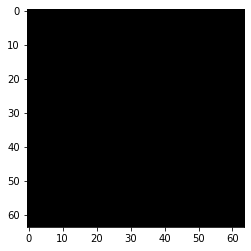

In [6]:
import numpy as np
import moderngl as gl
import matplotlib.pyplot as plt
import pyrr as pr
from tqdm import tqdm


class Camera():

    def __init__(self, ratio):
        self.position = pr.Vector3([0.0, 0.0, 0.0])
        self.front = pr.Vector3([0.0, 0.0, 1.0])
        self.up = pr.Vector3([0.0, 1.0, 0.0])

        self.yaw = -np.pi/2
        self.pitch = 0.0
        self.fov = np.pi/3
        self.ratio = ratio
        self.z_near = 0.1
        self.z_far = 1000.0


    def translate(self, x, y, z):
        self.position += self.right*x + self.up*y + self.front * z

    def rotate(self, pitch, yaw):
        self.pitch = max(-np.pi/2+0.1, min(np.pi/2-0.1, self.pitch + pitch))
        self.yaw += yaw

    def zoom(self, zoom):
        self.fov = max(0.1, min(np.pi/4, self.fov + zoom))

    def update(self):
        self.front = pr.vector.normalize(pr.Vector3([np.cos(self.yaw)*np.cos(self.pitch), np.sin(self.pitch), np.sin(self.yaw)*np.cos(self.pitch)]))
        self.right = pr.vector.normalize(self.front.cross(0.0, 1.0, 0.0))
        self.up = pr.vector.normalize(self.right, self.front)

    def model(self):
        return pr.matrix44.create_from_translation(self.position)

    def view(self):
        return pr.Matrix44.look_at(self.position, self.position + self.front, self.up)

    def projection(self):
        return pr.Matrix44.perspective_projection(self.fov, self.ratio, self.z_near, self.z_far)


def grid(size, steps):
    u = np.repeat(np.linspace(-size, size, steps), 2)
    v = np.tile([-size, size], steps)
    w = np.zeros(steps * 2)
    return np.concatenate([np.dstack([u, v, w]), np.dstack([v, u, w])])


gl_version = (3, 3)

ctx = gl.create_standalone_context()

prog = ctx.program(
    vertex_shader='''
        #version 330
        uniform mat4 mvp;
        in vec3 in_vert;
        void main() {
            gl_Position = mvp * vec4(in_vert, 1.0);
        }
    ''',
    fragment_shader='''
        #version 330
        out vec4 f_color;
        void main() {
            f_color = vec4(0.1, 0.1, 0.1, 1.0);
        }
    ''',
)

camera = Camera(1.0)
mvp = prog['mvp']
vbo = ctx.buffer(grid(15, 10).astype('f4'))
vao = ctx.simple_vertex_array(prog, vbo, 'in_vert')



ctx.enable(gl.DEPTH_TEST)

for _ in tqdm(range(1000)):
    fbo = ctx.simple_framebuffer((64, 64))
    fbo.use()
    fbo.clear(0.0, 0.0, 0.0, 1.0)

    mvp.write((camera.projection() * camera.view() * camera.model()).astype('f4'))
    vao.render(gl.LINES)

    buf = fbo.read(components=3, dtype='f4')

    img = np.frombuffer(buf, dtype='f4').reshape(64, 64, 3)

plt.imshow(img)
